## Байесовские методы для анализа коррозии KK-2

Этот ноутбук демонстрирует использование байесовских методов для анализа коррозии установки KK-2.

### Структура:
1. **Загрузка и подготовка данных** - загрузка данных, фильтрация по установке KK-2
2. **Анализ корреляций** - анализ корреляций признаков с целевой переменной
3. **Выбор лучшего набора признаков** - сравнение разных наборов признаков для определения оптимального
4. **Bayesian Ridge Regression** - линейная регрессия с байесовским подходом и оценкой неопределенности предсказаний
5. **Байесовская оптимизация Random Forest** - оптимизация гиперпараметров RF с помощью Optuna
6. **Сравнение методов** - сравнение Bayesian Ridge, оптимизированного RF и базового RF
7. **Анализ важности признаков** - анализ важности признаков для оптимизированной модели
8. **Резюме и выводы** - итоговые результаты и рекомендации

### Используемые методы:
- **BayesianCorrosionAnalyzer** из `src/bayesian_analysis.py`
- **AdvancedCorrosionAnalyzer** из `src/analysis.py` для базового анализа


In [1]:
# Импорты
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if '../src' not in sys.path:
    sys.path.append('../src')
from database import load_corrosion_data_new as load_data
from analysis import AdvancedCorrosionAnalyzer
from bayesian_analysis import BayesianCorrosionAnalyzer



In [2]:
# Настройки
sns.set(style='whitegrid')
TARGET = 'worst_corrosion_rate_mm_per_year'

# Загрузка
DF = load_data()
assert TARGET in DF.columns, 'В данных отсутствует corrosion_rate_mm_per_year'

print(f"Данные: {len(DF):,} строк, {len(DF.columns)} колонок")
print('Колонки:')
print(sorted(DF.columns.tolist()))

Данные: 143,060 строк, 45 колонок
Колонки:
['ammonia_content', 'avg_corrosion_rate_mm_per_year', 'chloride_aggressiveness', 'chlorine_content', 'co2_content', 'component_type_id', 'component_type_name', 'contour', 'corrosion_aggressiveness_index', 'corrosion_inhibitor_content', 'corrosion_protection_index', 'cross_sectional_area', 'diameter_to_thickness_ratio', 'equipment', 'equipment_age_years', 'h2s_aggressiveness_index', 'h2s_content', 'h2s_water_ratio', 'hydrochloric_acid_content', 'inner_diameter', 'installation', 'material_code', 'material_resistance_score', 'material_type', 'measurement_date', 'measurement_points_in_section', 'min_corrosion_rate_mm_per_year', 'nominal_thickness_mmc', 'operating_pressure', 'operating_temperature', 'outer_diameter', 'oxygen_content', 'pitting_corrosion_index', 'section_number', 'stress_corrosion_index', 'tmin_mmc', 'total_acidity_index', 'total_acids', 'total_chlorine_compounds', 'total_sulfur_compounds', 'underdeposit_corrosion_index', 'wall_thic

In [3]:
# Фильтрация по конкретной установке
INSTALLATION_FILTER = 'KK-2'
DF = DF[DF['installation'] == INSTALLATION_FILTER]

print(f"После фильтрации по '{INSTALLATION_FILTER}': {len(DF):,} строк")

После фильтрации по 'KK-2': 11,466 строк


✅ Добавлены инженерные индексы: 11 колонок
   Колонки: ['h2s_aqueous_exposure', 'co2_aqueous_temp_index', 'acid_load_aqueous', 'chloride_aqueous', 'oxygen_aqueous', 'mixed_acid_gas_index', 'aggressiveness_per_resistance', 'protection_gap', 'pitting_chloride_index', 'hoop_stress_proxy', 'material_adjusted_stress']


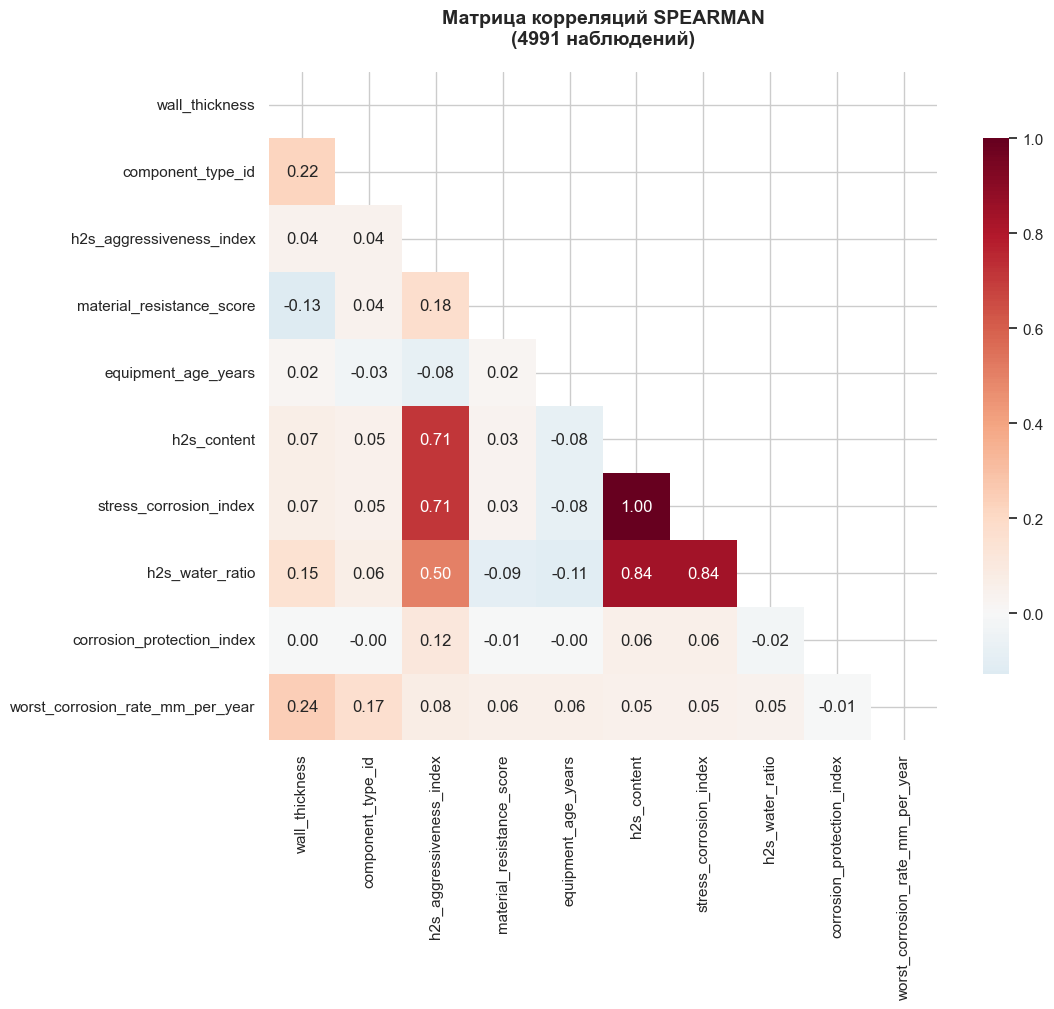

ТОП-9 ПРИЗНАКОВ ПО КОРРЕЛЯЦИИ SPEARMAN

📈 СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ (p < 0.05):
  wall_thickness                 | r =   0.244 *** 🡅
  component_type_id              | r =   0.167 *** 🡅
  h2s_aggressiveness_index       | r =   0.077 *** 🡅
  material_resistance_score      | r =   0.061 *** 🡅
  equipment_age_years            | r =   0.060 *** 🡅
  h2s_content                    | r =   0.054 *** 🡅
  stress_corrosion_index         | r =   0.054 *** 🡅
  h2s_water_ratio                | r =   0.047 *** 🡅

📊 Статистика:
   Всего значимых корреляций: 8
   Максимальная корреляция: 0.244
   Минимальная корреляция: 0.007


In [4]:
# 1. Инициализация с любыми данными
analyzer = AdvancedCorrosionAnalyzer(DF)
# Обогощаем данные
added_cols = analyzer.add_engineered_indices()

# 2. Установка целевой переменной
analyzer.set_target('worst_corrosion_rate_mm_per_year')

# 3. Анализ корреляций для конкретных колонок
features_to_analyze = ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','corrosion_protection_index','stress_corrosion_index']

correlations = analyzer.analyze_correlations(
    feature_columns=features_to_analyze,
    method='spearman',
    top_k=15,
    plot_matrix=True
)


🔬 Тестируем набор: 1
   Признаки: ['operating_temperature', 'operating_pressure', 'material_resistance_score']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0034 | MAE =  0.0618 | RMSE =  0.1002
   random_forest   | R² =  0.2110 | MAE =  0.0575 | RMSE =  0.0892

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.2110)

🔬 Тестируем набор: 2
   Признаки: ['cross_sectional_area', 'component_type_id', 'nominal_thickness_mmc', 'h2s_content', 'operating_temperature', 'operating_pressure', 'water_content']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0975 | MAE =  0.0658 | RMSE =  0.0879
   random_forest   | R² =  0.2346 | MAE =  0.0549 | RMSE =  0.0809

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.2346)

🔬 Тестируем набор: 3
   Признаки: ['h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0755 | MAE =  0.0657 | RMSE =  0.0889
   random_forest   | R² =  0.2975 | MAE =  0.0553 

<Figure size 1200x600 with 0 Axes>

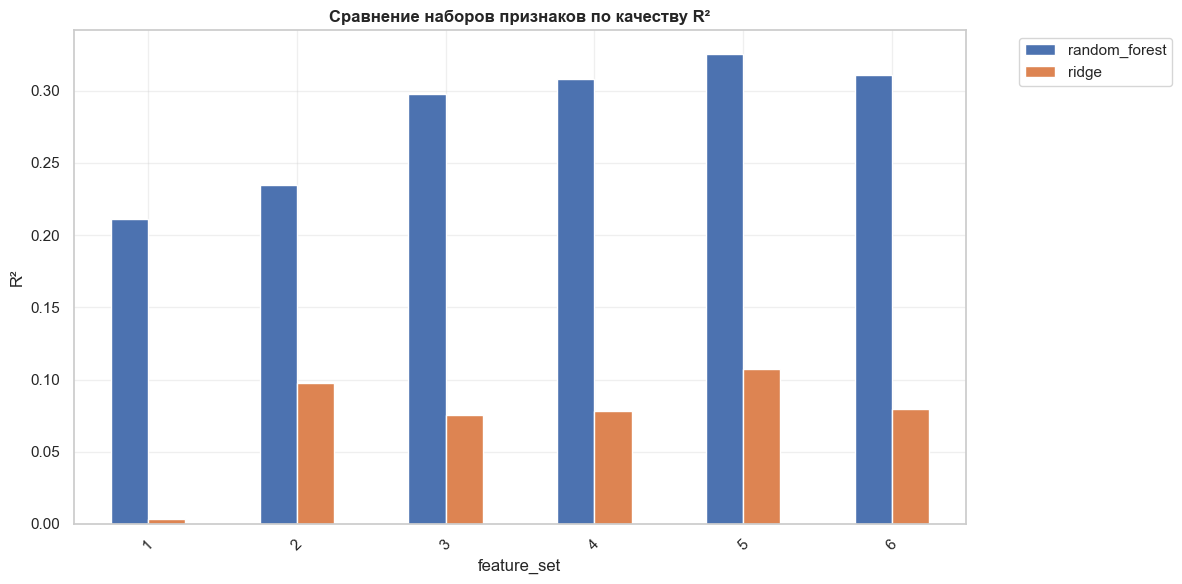

In [5]:
# 5. Сравнение разных наборов признаков
feature_sets = {
    '1': ['operating_temperature', 'operating_pressure', 'material_resistance_score'],
    '2': ['cross_sectional_area','component_type_id','nominal_thickness_mmc','h2s_content','operating_temperature','operating_pressure','water_content'],
    '3': ['h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years'],
    '4': ['h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
    '5': ['h2s_aggressiveness_index', 'h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
    '6': ['h2s_content', 'h2s_water_ratio', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
}

comparison = analyzer.compare_feature_sets(feature_sets)


🔬 Тестируем набор: 5
   Признаки: ['h2s_aggressiveness_index', 'h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.1076 | MAE =  0.0655 | RMSE =  0.0874
   random_forest   | R² =  0.3254 | MAE =  0.0531 | RMSE =  0.0760

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.3254)

🔬 Тестируем набор: 6
   Признаки: ['h2s_content', 'h2s_water_ratio', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0797 | MAE =  0.0657 | RMSE =  0.0887
   random_forest   | R² =  0.3111 | MAE =  0.0534 | RMSE =  0.0768

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.3111)

🔬 Тестируем набор: 7
   Признаки: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type

<Figure size 1200x600 with 0 Axes>

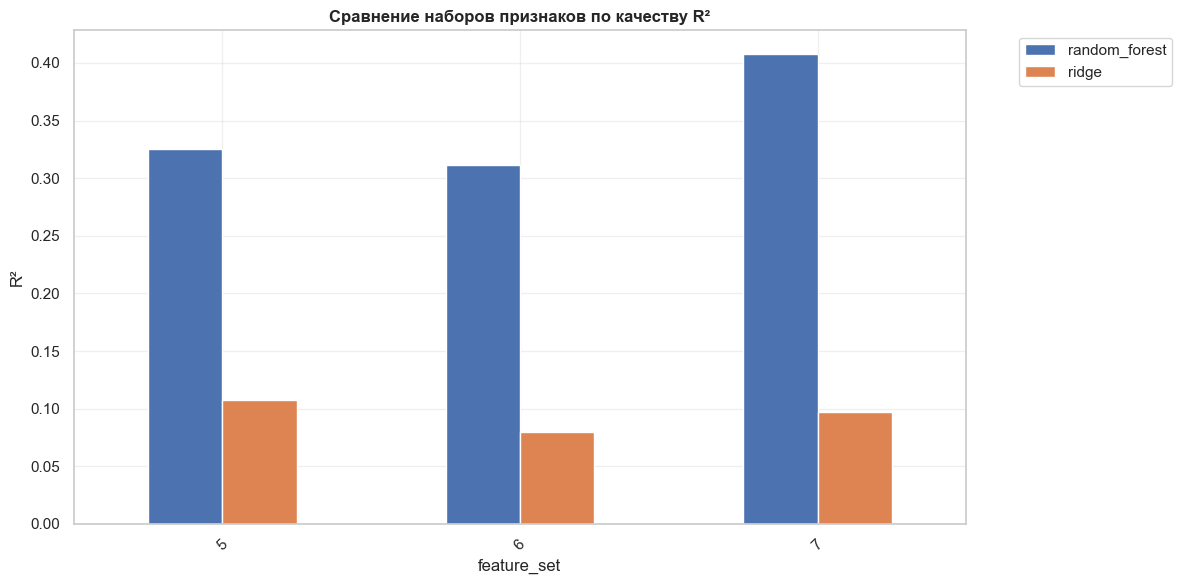

In [6]:
# 6. Сравнение разных наборов признаков
feature_sets = {
    '5': ['h2s_aggressiveness_index', 'h2s_content', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
    '6': ['h2s_content', 'h2s_water_ratio', 'water_content', 'operating_temperature', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
    '7': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],

}

comparison = analyzer.compare_feature_sets(feature_sets)


🔬 Тестируем набор: 7
   Признаки: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0973 | MAE =  0.0694 | RMSE =  0.0968
   random_forest   | R² =  0.4079 | MAE =  0.0515 | RMSE =  0.0784

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.4079)

🔬 Тестируем набор: 8
   Признаки: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id', 'stress_corrosion_index']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0973 | MAE =  0.0694 | RMSE =  0.0968
   random_forest   | R² =  0.4109 | MAE =  0.0514 | RMSE =  0.0782

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.4109)

🔬 Тестируем набор: 9
   Признаки: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id', 'corr

<Figure size 1200x600 with 0 Axes>

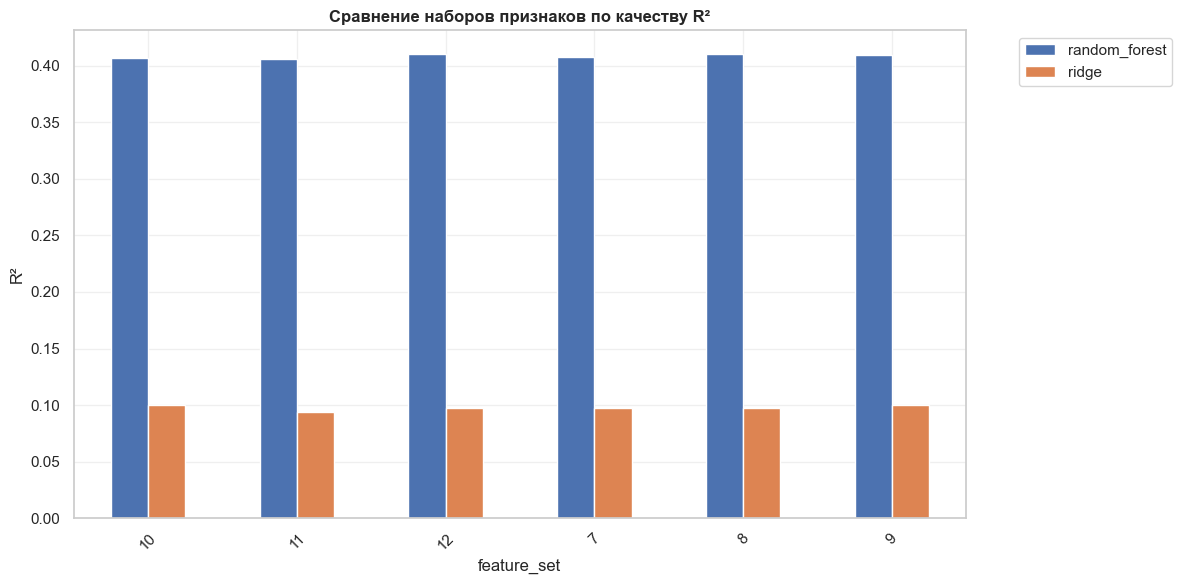

In [7]:
# 6. Сравнение разных наборов признаков
feature_sets = {
    '7': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id'],
    '8': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','stress_corrosion_index'],
    '9': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','corrosion_protection_index'],
    '10': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','corrosion_protection_index','stress_corrosion_index'], 
    '11': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','corrosion_protection_index','cross_sectional_area'], 
    '12': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','stress_corrosion_index'],

    
}


comparison = analyzer.compare_feature_sets(feature_sets)


🔬 Тестируем набор: baseline
   Признаки: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id', 'stress_corrosion_index']
📊 РЕЗУЛЬТАТЫ МОДЕЛЕЙ
   ridge           | R² =  0.0973 | MAE =  0.0694 | RMSE =  0.0968
   random_forest   | R² =  0.4109 | MAE =  0.0514 | RMSE =  0.0782

🎯 ЛУЧШАЯ МОДЕЛЬ: random_forest (R² = 0.4109)

📋 Сводная таблица по наборам признаков (Random Forest):
                  R2 Random Forest  MAE Random Forest
Набор параметров                                     
baseline                    0.4109             0.0514


<Figure size 1200x600 with 0 Axes>

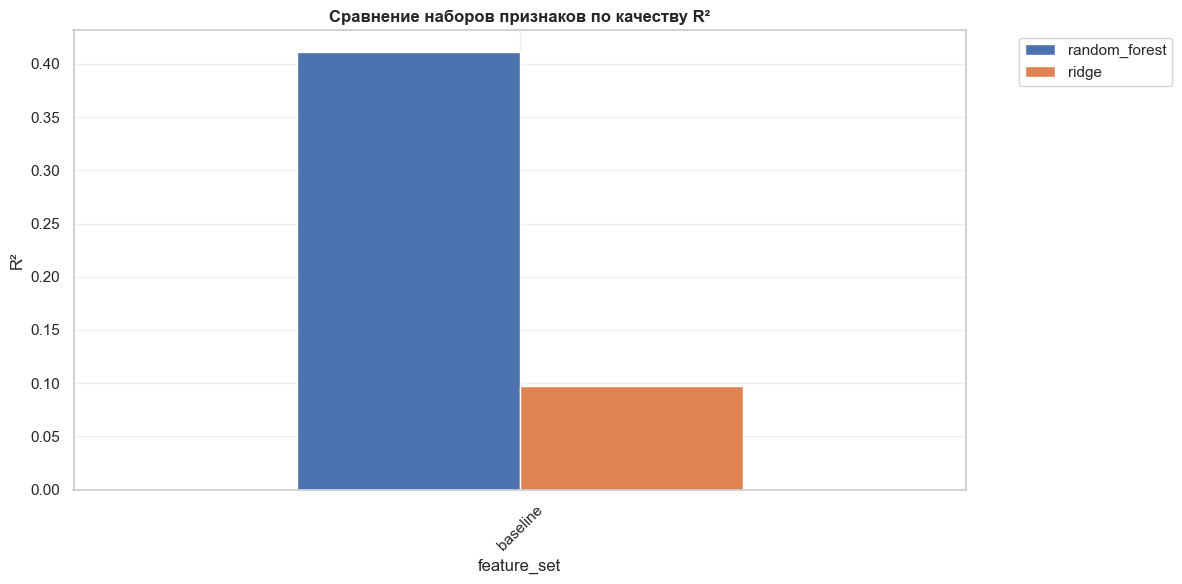


✅ Лучший набор признаков для байесовских методов: ['h2s_content', 'h2s_water_ratio', 'h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years', 'component_type_id', 'stress_corrosion_index']


In [8]:
# 6. Определение лучшего набора признаков (baseline)
feature_sets = {
    'baseline': ['h2s_content', 'h2s_water_ratio','h2s_aggressiveness_index', 'material_resistance_score', 'wall_thickness', 'equipment_age_years','component_type_id','stress_corrosion_index'],
}

comparison = analyzer.compare_feature_sets(feature_sets)

# Сохраняем лучший набор признаков для байесовских методов
best_features = feature_sets['baseline']
print(f"\n✅ Лучший набор признаков для байесовских методов: {best_features}")

## Байесовские методы

Теперь используем новые байесовские методы:
1. **Bayesian Ridge Regression** - с оценкой неопределенности предсказаний
2. **Байесовская оптимизация гиперпараметров** - для Random Forest
3. **Сравнение методов** - Bayesian Ridge vs оптимизированный RF vs базовый RF


In [9]:
# Инициализация байесовского анализатора с подготовленными данными
# Используем данные с добавленными инженерными индексами
DF_prepared = analyzer.data.copy()

bayesian_analyzer = BayesianCorrosionAnalyzer(DF_prepared)
bayesian_analyzer.set_target(TARGET)

print(f"✅ Байесовский анализатор инициализирован")
print(f"   Данных: {len(DF_prepared):,} строк")
print(f"   Признаков: {len(DF_prepared.columns)} колонок")
print(f"   Целевая переменная: {TARGET}")


✅ Байесовский анализатор инициализирован
   Данных: 11,466 строк
   Признаков: 56 колонок
   Целевая переменная: worst_corrosion_rate_mm_per_year


### 1. Bayesian Ridge Regression


In [10]:
# Обучение Bayesian Ridge с оценкой неопределенности
print("="*70)
print("1️⃣ BAYESIAN RIDGE REGRESSION")
print("="*70)

br_result = bayesian_analyzer.train_bayesian_ridge(
    feature_columns=best_features,
    test_size=0.2,
    random_state=42,
    n_iter=300,
    compute_score=True
)


1️⃣ BAYESIAN RIDGE REGRESSION
📊 РЕЗУЛЬТАТЫ BAYESIAN RIDGE
   R² =  0.0978
   MAE =  0.0694
   RMSE =  0.0968
   Alpha (точность шума) = 91.060288
   Lambda (регуляризация) = 5316.236812
   Средняя неопределенность = 0.104885
   Количество признаков: 8
   Количество образцов: 4991


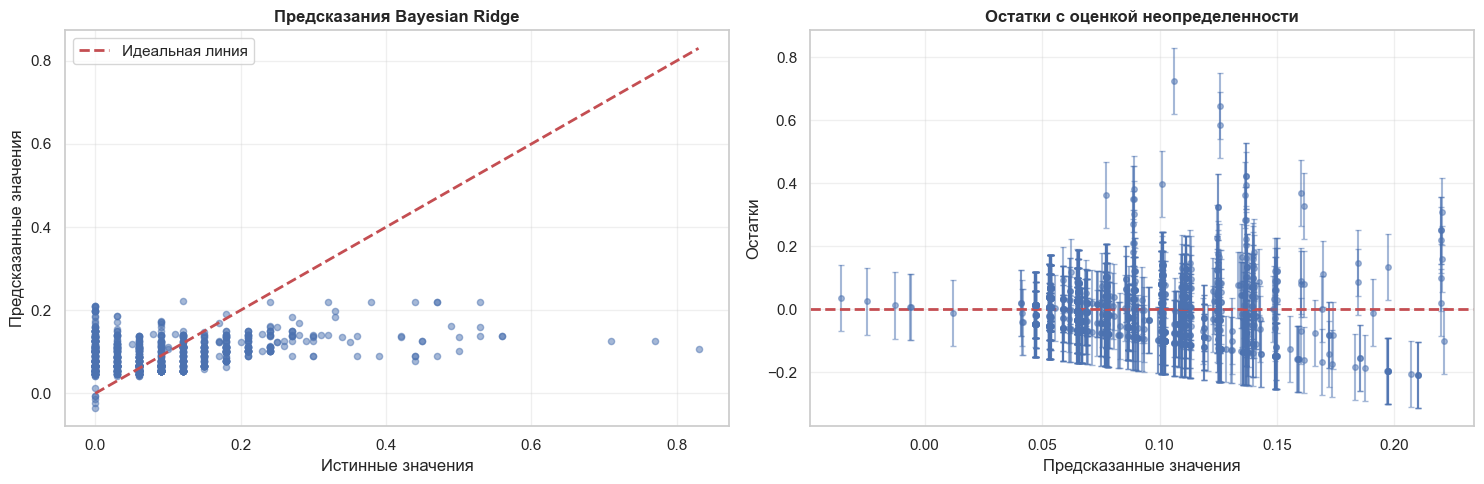

In [11]:
# Визуализация неопределенности предсказаний
if 'bayesian_ridge' in bayesian_analyzer.results:
    try:
        bayesian_analyzer.plot_uncertainty('bayesian_ridge')
    except Exception as e:
        print(f"⚠️ Не удалось визуализировать неопределенность: {e}")
        print("   Это нормально, если оценка неопределенности недоступна")


### 2. Байесовская оптимизация Random Forest


In [12]:
# Байесовская оптимизация гиперпараметров Random Forest
print("\n" + "="*70)
print("2️⃣ БАЙЕСОВСКАЯ ОПТИМИЗАЦИЯ RANDOM FOREST")
print("="*70)
print("⚠️ Это может занять несколько минут...")

rf_optimized = bayesian_analyzer.optimize_random_forest_bayesian(
    feature_columns=best_features,
    n_trials=50,  # Количество попыток оптимизации (можно увеличить до 100 для лучших результатов)
    test_size=0.2,
    random_state=42,
    cv_folds=5,
    use_optuna=True  # Использовать Optuna (или False для scikit-optimize)
)


[I 2025-11-08 15:47:48,668] A new study created in memory with name: no-name-d9bb279c-c2d6-4246-8be3-a27e722f69a7



2️⃣ БАЙЕСОВСКАЯ ОПТИМИЗАЦИЯ RANDOM FOREST
⚠️ Это может занять несколько минут...
🔍 Начинаем байесовскую оптимизацию с Optuna (50 trials)...


[I 2025-11-08 15:47:52,167] Trial 0 finished with value: 0.008233985929196993 and parameters: {'n_estimators': 257, 'max_depth': 22, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.008233985929196993.
[I 2025-11-08 15:47:54,427] Trial 1 finished with value: 0.008969279723980332 and parameters: {'n_estimators': 321, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 0.008233985929196993.
[I 2025-11-08 15:47:57,707] Trial 2 finished with value: 0.008601635502282023 and parameters: {'n_estimators': 306, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.008233985929196993.
[I 2025-11-08 15:48:02,817] Trial 3 finished with value: 0.008592558371806476 and parameters: {'n_estimators': 498, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.0082

📊 РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ (Optuna)
   Лучший score (CV): 0.007628
   R² (test) =  0.4293
   MAE (test) =  0.0519
   RMSE (test) =  0.0770

   Лучшие параметры:
     n_estimators: 131
     max_depth: 16
     min_samples_split: 6
     min_samples_leaf: 1
     max_features: log2


In [13]:
# Визуализация процесса оптимизации (если используется Optuna)
if 'optimized_rf' in bayesian_analyzer.results and 'study' in bayesian_analyzer.results['optimized_rf']:
    try:
        import optuna.visualization as vis
        
        print("\n📊 Визуализация процесса оптимизации...")
        
        # График истории оптимизации
        try:
            fig = vis.plot_optimization_history(rf_optimized['study'])
            fig.show()
        except Exception as e:
            print(f"⚠️ Не удалось построить график истории: {e}")
        
        # Важность гиперпараметров
        try:
            fig = vis.plot_param_importances(rf_optimized['study'])
            fig.show()
        except Exception as e:
            print(f"⚠️ Не удалось построить график важности: {e}")
            
    except ImportError:
        print("⚠️ Optuna visualization недоступна (можно установить: pip install optuna[visualization])")
    except Exception as e:
        print(f"⚠️ Ошибка визуализации: {e}")



📊 Визуализация процесса оптимизации...
⚠️ Не удалось построить график истории: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.
⚠️ Не удалось построить график важности: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.


### 3. Сравнение всех методов


[I 2025-11-08 15:49:25,435] A new study created in memory with name: no-name-31afc562-efde-4bab-80e0-1a604c9c9717



3️⃣ СРАВНЕНИЕ ВСЕХ БАЙЕСОВСКИХ МЕТОДОВ
🔬 СРАВНЕНИЕ БАЙЕСОВСКИХ МЕТОДОВ

1️⃣ Обучение Bayesian Ridge...
📊 РЕЗУЛЬТАТЫ BAYESIAN RIDGE
   R² =  0.0978
   MAE =  0.0694
   RMSE =  0.0968
   Alpha (точность шума) = 91.060288
   Lambda (регуляризация) = 5316.236812
   Средняя неопределенность = 0.104885
   Количество признаков: 8
   Количество образцов: 4991

2️⃣ Байесовская оптимизация Random Forest...
🔍 Начинаем байесовскую оптимизацию с Optuna (30 trials)...


[I 2025-11-08 15:49:27,203] Trial 0 finished with value: 0.008572002020425237 and parameters: {'n_estimators': 232, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.008572002020425237.
[I 2025-11-08 15:49:28,373] Trial 1 finished with value: 0.008071178694730079 and parameters: {'n_estimators': 168, 'max_depth': 9, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.008071178694730079.
[I 2025-11-08 15:49:31,029] Trial 2 finished with value: 0.00840365786092892 and parameters: {'n_estimators': 380, 'max_depth': 22, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 0.008071178694730079.
[I 2025-11-08 15:49:31,765] Trial 3 finished with value: 0.0091927947272373 and parameters: {'n_estimators': 139, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.008071

📊 РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ (Optuna)
   Лучший score (CV): 0.007712
   R² (test) =  0.4292
   MAE (test) =  0.0521
   RMSE (test) =  0.0770

   Лучшие параметры:
     n_estimators: 207
     max_depth: 28
     min_samples_split: 7
     min_samples_leaf: 1
     max_features: log2

3️⃣ Базовый Random Forest (для сравнения)...

📊 РЕЗУЛЬТАТЫ СРАВНЕНИЯ
                 method       r2      mae     rmse  has_uncertainty                                                                                                                                     best_params
         Bayesian Ridge 0.097767 0.069365 0.096777             True                                                                                                                                             NaN
RF (Bayesian Optimized) 0.429174 0.052129 0.076977            False {'n_estimators': 207, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'random_state': 42, 'n_jobs': -1}
          RF (Base

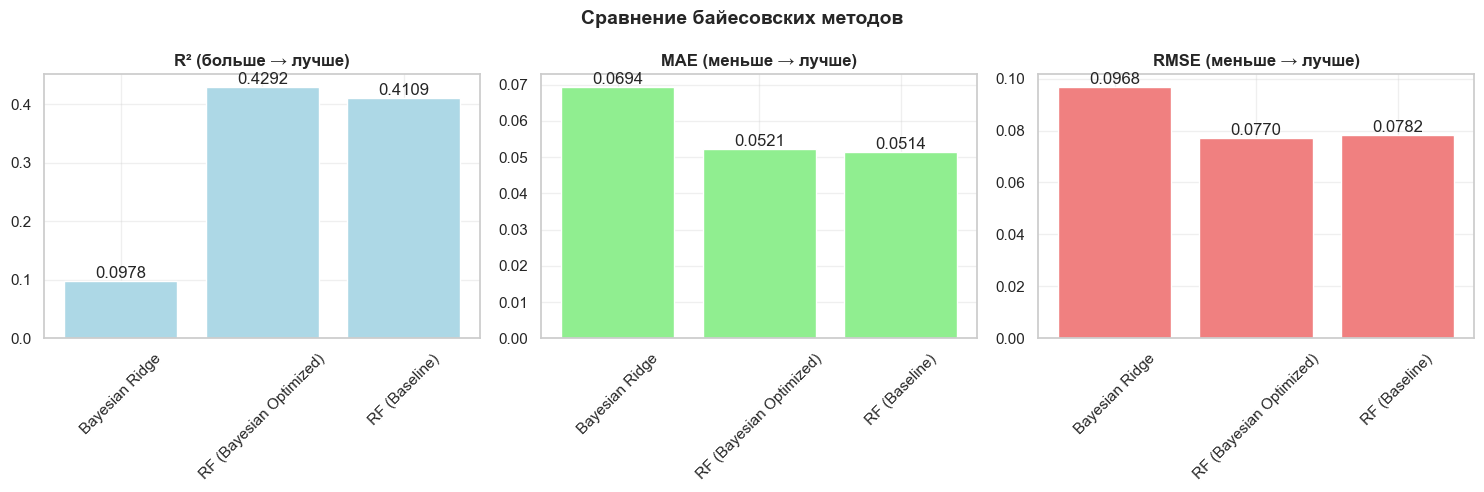

In [14]:
# Сравнение Bayesian Ridge, оптимизированного RF и базового RF
print("\n" + "="*70)
print("3️⃣ СРАВНЕНИЕ ВСЕХ БАЙЕСОВСКИХ МЕТОДОВ")
print("="*70)

comparison_bayesian = bayesian_analyzer.compare_bayesian_methods(
    feature_columns=best_features,
    test_size=0.2,
    random_state=42,
    n_trials=30  # Можно уменьшить для быстрого теста, увеличить для лучших результатов
)


In [15]:
# Детальное сравнение результатов
print("\n" + "="*70)
print("📊 ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ")
print("="*70)

if 'comparison' in bayesian_analyzer.results:
    comp_df = bayesian_analyzer.results['comparison']
    print("\nСравнение методов:")
    print(comp_df.to_string(index=False))
    
    # Находим лучший метод
    best_method = comp_df.loc[comp_df['r2'].idxmax(), 'method']
    best_r2 = comp_df.loc[comp_df['r2'].idxmax(), 'r2']
    best_mae = comp_df.loc[comp_df['r2'].idxmax(), 'mae']
    print(f"\n🎯 ЛУЧШИЙ МЕТОД: {best_method}")
    print(f"   R² = {best_r2:.4f}")
    print(f"   MAE = {best_mae:.4f}")
    
    # Сравнение с базовым RF из предыдущего анализа
    if 'baseline' in comparison['feature_set'].values:
        baseline_rf = comparison[
            (comparison['feature_set'] == 'baseline') & 
            (comparison['model'] == 'random_forest')
        ]
        if not baseline_rf.empty:
            baseline_r2 = baseline_rf['r2'].values[0]
            print(f"\n📈 Улучшение по сравнению с базовым RF:")
            print(f"   Базовый RF: R² = {baseline_r2:.4f}")
            print(f"   Лучший байесовский: R² = {best_r2:.4f}")
            improvement = ((best_r2 - baseline_r2) / baseline_r2) * 100
            print(f"   Улучшение: {improvement:+.2f}%")



📊 ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ

Сравнение методов:
                 method       r2      mae     rmse  has_uncertainty                                                                                                                                     best_params
         Bayesian Ridge 0.097767 0.069365 0.096777             True                                                                                                                                             NaN
RF (Bayesian Optimized) 0.429174 0.052129 0.076977            False {'n_estimators': 207, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'random_state': 42, 'n_jobs': -1}
          RF (Baseline) 0.410947 0.051447 0.078197            False                                                                                                                                             NaN

🎯 ЛУЧШИЙ МЕТОД: RF (Bayesian Optimized)
   R² = 0.4292
   MAE = 0.0521

📈 Улучшение по сравнению с ба

### 4. Анализ важности признаков (для оптимизированного RF)


📊 Важность признаков (Bayesian Optimized RF):
                  feature  importance
           wall_thickness    0.382909
        component_type_id    0.128750
material_resistance_score    0.125593
 h2s_aggressiveness_index    0.101226
   stress_corrosion_index    0.081381
              h2s_content    0.078857
          h2s_water_ratio    0.063385
      equipment_age_years    0.037901


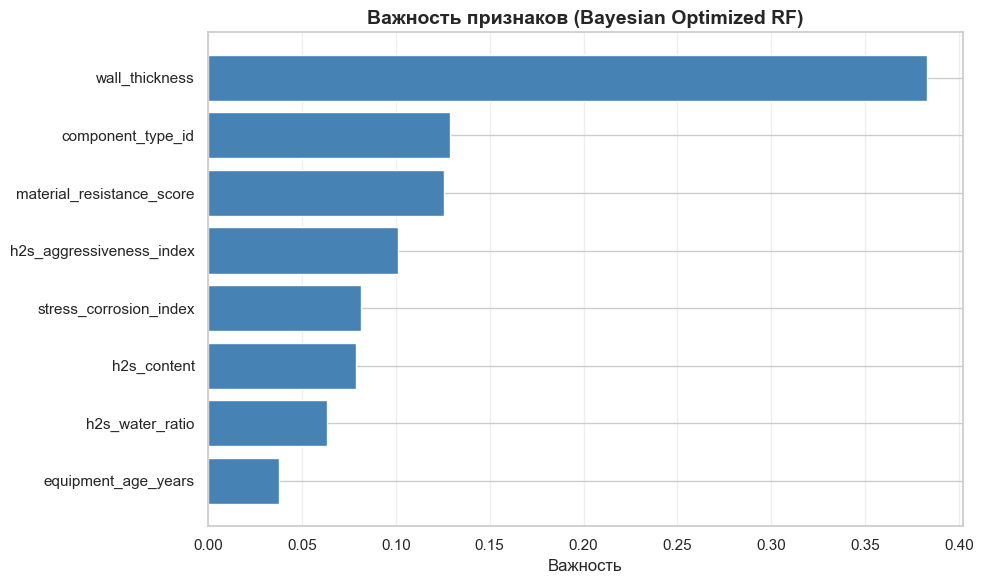


📊 Сравнение с базовым RF:
   Базовый RF: R² = 0.4109, MAE = 0.0514
   Оптимизированный RF: R² = 0.4293, MAE = 0.0519

🔧 Лучшие гиперпараметры:
   n_estimators: 131
   max_depth: 16
   min_samples_split: 6
   min_samples_leaf: 1
   max_features: log2


In [16]:
# Важности признаков для оптимизированного Random Forest
if 'optimized_rf' in bayesian_analyzer.results:
    rf_model = bayesian_analyzer.results['optimized_rf']['best_model']
    features = bayesian_analyzer.results['optimized_rf']['features']
    
    importances = pd.DataFrame({
        'feature': features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("📊 Важность признаков (Bayesian Optimized RF):")
    print("="*70)
    print(importances.to_string(index=False))
    
    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    plt.barh(importances['feature'], importances['importance'], color='steelblue')
    plt.xlabel('Важность', fontsize=12)
    plt.title('Важность признаков (Bayesian Optimized RF)', fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Сравнение с базовым RF (если есть)
    if 'baseline' in comparison['feature_set'].values:
        baseline_rf_row = comparison[
            (comparison['feature_set'] == 'baseline') & 
            (comparison['model'] == 'random_forest')
        ]
        if not baseline_rf_row.empty:
            print("\n📊 Сравнение с базовым RF:")
            print(f"   Базовый RF: R² = {baseline_rf_row['r2'].values[0]:.4f}, MAE = {baseline_rf_row['mae'].values[0]:.4f}")
            print(f"   Оптимизированный RF: R² = {rf_optimized['metrics']['r2']:.4f}, MAE = {rf_optimized['metrics']['mae']:.4f}")
            
            print(f"\n🔧 Лучшие гиперпараметры:")
            for key, value in rf_optimized['best_params'].items():
                if key not in ['random_state', 'n_jobs']:
                    print(f"   {key}: {value}")


### 5. Резюме и выводы


In [17]:
# Итоговое резюме
print("="*70)
print("📋 ИТОГОВОЕ РЕЗЮМЕ")
print("="*70)

print(f"\n✅ Использованный набор признаков ({len(best_features)}):")
for i, feat in enumerate(best_features, 1):
    print(f"   {i}. {feat}")

print(f"\n📊 Результаты методов:")
if 'comparison' in bayesian_analyzer.results:
    comp_df = bayesian_analyzer.results['comparison']
    for _, row in comp_df.iterrows():
        print(f"\n   {row['method']}:")
        print(f"      R²  = {row['r2']:.4f}")
        print(f"      MAE = {row['mae']:.4f}")
        print(f"      RMSE = {row['rmse']:.4f}")
        if 'has_uncertainty' in row and row['has_uncertainty']:
            print(f"      ✅ Оценка неопределенности доступна")

print(f"\n💾 Результаты сохранены в bayesian_analyzer.results")
print(f"   Доступные ключи: {list(bayesian_analyzer.results.keys())}")

# Сохранение лучшей модели (опционально)
if 'optimized_rf' in bayesian_analyzer.results:
    print(f"\n🎯 Рекомендация: использовать оптимизированный Random Forest")
    print(f"   Лучшие параметры сохранены в bayesian_analyzer.results['optimized_rf']['best_params']")
    print(f"   Модель доступна через: bayesian_analyzer.results['optimized_rf']['best_model']")


📋 ИТОГОВОЕ РЕЗЮМЕ

✅ Использованный набор признаков (8):
   1. h2s_content
   2. h2s_water_ratio
   3. h2s_aggressiveness_index
   4. material_resistance_score
   5. wall_thickness
   6. equipment_age_years
   7. component_type_id
   8. stress_corrosion_index

📊 Результаты методов:

   Bayesian Ridge:
      R²  = 0.0978
      MAE = 0.0694
      RMSE = 0.0968
      ✅ Оценка неопределенности доступна

   RF (Bayesian Optimized):
      R²  = 0.4292
      MAE = 0.0521
      RMSE = 0.0770

   RF (Baseline):
      R²  = 0.4109
      MAE = 0.0514
      RMSE = 0.0782

💾 Результаты сохранены в bayesian_analyzer.results
   Доступные ключи: ['bayesian_ridge', 'optimized_rf', 'comparison']

🎯 Рекомендация: использовать оптимизированный Random Forest
   Лучшие параметры сохранены в bayesian_analyzer.results['optimized_rf']['best_params']
   Модель доступна через: bayesian_analyzer.results['optimized_rf']['best_model']
